In [2]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(10)

# Single Agent

## Environment

In [3]:
class GridworldEnv(gym.Env):
    def __init__(self, rows, cols, wind_policy, goal_state, trap_state):
        super(GridworldEnv, self).__init__()

        self.rows = rows
        self.cols = cols
        self.wind_policy = wind_policy
        self.goal_state = goal_state
        self.trap_state = trap_state

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(rows * cols)

        # Agent's initial position
        self.agent_pos = (4, 0)

    def reset(self):
        # Reset the agent to the initial position
        self.agent_pos = (4, 0)
        return self.agent_pos

    def step(self, action):
        # Possible movements
        movements = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Right, Left, Down, Up

        # Apply wind effect based on policy
        wind_effect = int(self.wind_policy[self.agent_pos])

        # Update agent's position with wind effect
        next_pos = (
            self.agent_pos[0] + movements[action][0] + wind_effect,
            self.agent_pos[1] + movements[action][1]
        )

        # Clip agent's position to stay within the grid
        next_pos = (
            np.clip(next_pos[0], 0, self.rows - 1),
            np.clip(next_pos[1], 0, self.cols - 1)
        )

        # Update agent's position
        self.agent_pos = next_pos

        # Define rewards
        if self.agent_pos == self.goal_state:
            reward = 10  # Goal state, no additional reward
        elif self.agent_pos == self.trap_state:
            reward = -10  # Trap state, penalty
        else:
            reward = -1  # Default step penalty

        # Check if the agent reached the goal
        done = (self.agent_pos == self.goal_state) #or (self.agent_pos == self.trap_state)

        return self.agent_pos, reward, done, {}

## Q-learning

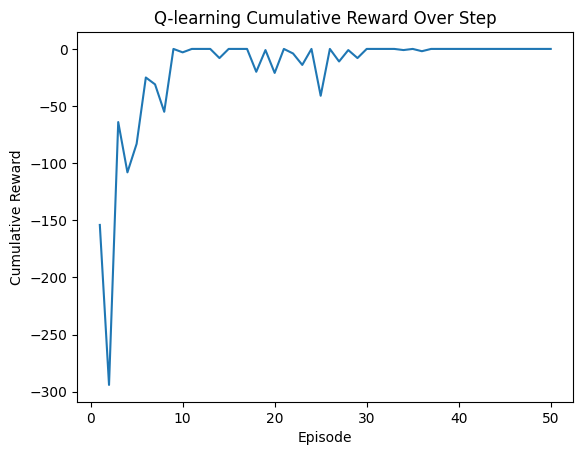

In [4]:
np.random.seed(10)
# Parameters
learning_rate = 0.8
discount_factor = 0.9
epsilon = 1
decay_rate = 0.002
num_episodes = 50
min_epsilon = 0.05 
convergence_threshold = 0.0001
# Initialize Q-values
rows, cols = 8, 8
goal_state = (4, 8)
trap_state = (4, 4)
wind_policy = np.zeros((rows, cols))
wind_policy[:, 3:6] = 1
wind_policy[:, 6:8] = 2
q_values = np.zeros((rows, cols, 4))  # 4 actions: Up, Down, Left, Right

# Gym environment
env = GridworldEnv(rows, cols, wind_policy, goal_state, trap_state)

# Function to choose an action using epsilon-greedy policy
def epsilon_greedy_policy(state):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(env.action_space.n)
    else:
        return np.argmax(q_values[state])

# List to store cumulative rewards at each step
cumulative_rewards = []

# Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    # Update exploration rate
    if epsilon > min_epsilon:
        epsilon -= decay_rate

    while not done:
        action = epsilon_greedy_policy(state)
        next_state, reward, done, _ = env.step(action)
        # Store the old Q-value for convergence check
        old_q_value = q_values[state[0], state[1], action]

        # Update Q-values using the Q-learning update rule
        q_values[state[0], state[1], action] += learning_rate * (
            reward + discount_factor * np.max(q_values[next_state[0], next_state[1], :]) - q_values[state[0], state[1], action]
        )

        # Check for convergence
        if abs(q_values[state[0], state[1], action] - old_q_value) < convergence_threshold:
            break

        state = next_state
        total_reward += reward
    cumulative_rewards.append(total_reward)

# Plot cumulative rewards
plt.plot(np.arange(1, num_episodes + 1), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Q-learning Cumulative Reward Over Step')
plt.show()

## Actor-Critic

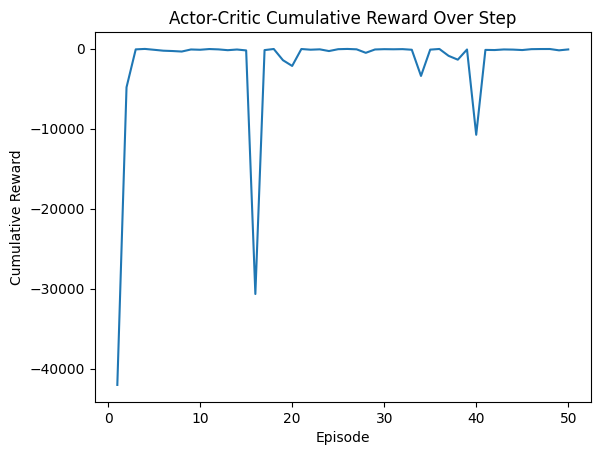

In [5]:
class ActorCriticAgent:
    def __init__(self, state_space, action_space, learning_rate, discount_factor, entropy_weight):
        self.state_space = state_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.entropy_weight = entropy_weight

        # Initialize actor and critic parameters
        self.actor = np.zeros((state_space[0], state_space[1], action_space.n))
        self.critic = np.zeros((state_space[0], state_space[1]))

    def select_action(self, state):
        # Softmax policy for actor
        logits = self.actor[state[0], state[1], :]
        probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=-1)
        action = np.random.choice(self.action_space.n, p=probabilities)
        return action

    def update(self, state, action, next_state, reward, done):
        # TD error for critic
        td_error = reward + (1 - done) * self.discount_factor * self.critic[next_state[0], next_state[1]] - self.critic[state[0], state[1]]

        # Critic update
        self.critic[state[0], state[1]] += self.learning_rate * td_error

        # Advantage for actor
        advantage = td_error

        # Actor update using policy gradient
        self.actor[state[0], state[1], action] += self.learning_rate * advantage

# Parameters
learning_rate = 0.001
discount_factor = 0.9
entropy_weight = 0.01
num_episodes = 50
convergence_threshold = 0.0001

# Initialize agent
rows, cols = 8, 8
goal_state = (4, 8)
trap_state = (4, 4)
wind_policy = np.zeros((rows, cols))
wind_policy[:, 3:6] = 1
wind_policy[:, 6:8] = 2
state_space = (rows, cols)
action_space = spaces.Discrete(4)
agent = ActorCriticAgent(state_space, action_space, learning_rate, discount_factor, entropy_weight)

# Gym environment
env = GridworldEnv(rows, cols, wind_policy, goal_state, trap_state)

# List to store cumulative rewards at each step
cumulative_reward = []

# Actor-Critic algorithm
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    avg_td_error = 0.0

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, next_state, reward, done)

        # Calculate TD error for convergence check
        td_error = reward + (1 - done) * agent.discount_factor * agent.critic[next_state[0], next_state[1]] - agent.critic[state[0], state[1]]
        avg_td_error += np.abs(td_error)

        state = next_state
        total_reward += reward
        # Calculate average TD error
        avg_td_error /= env.observation_space.n
        # Check for convergence
        if avg_td_error < convergence_threshold:
            break

    cumulative_reward.append(total_reward)

# Plot cumulative rewards
plt.plot(np.arange(1, num_episodes + 1), cumulative_reward)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Actor-Critic Cumulative Reward Over Step')
plt.show()

# Multi Agent

## Minimax Q-learning algorithm

C:\Users\hp\AppData\Local\Temp\ipykernel_22412\3336709761.py:119: RuntimeWarning: overflow encountered in scalar add
  q_values_adversary[state[0], state[1], adversary_action, state[2]] += learning_rate * (


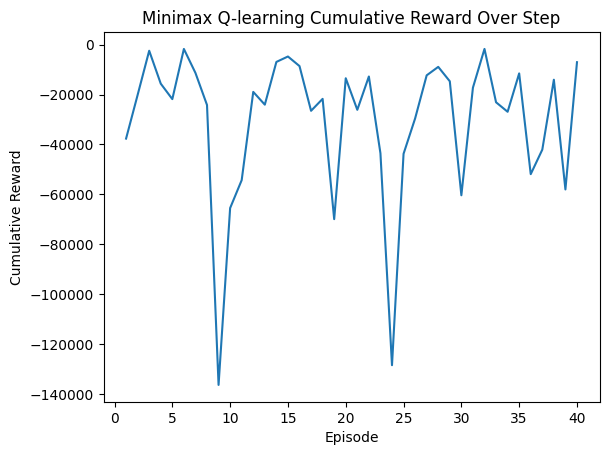

In [19]:
np.random.seed(10)
class MultiAgentGridworldEnv(gym.Env):
    def __init__(self, rows, cols, goal_state, trap_state):
        super(MultiAgentGridworldEnv, self).__init__()

        self.rows = rows
        self.cols = cols
        self.goal_state = goal_state
        self.trap_state = trap_state

        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Discrete(rows * cols * 5)  # 5 for agent's previous action

        # Agent's initial position
        self.agent_pos = (4, 0)
        self.agent_prev_action = None

    def reset(self):
        # Reset the agent to the initial position
        self.agent_pos = (4, 0)
        self.agent_prev_action = None
        return self._get_state()

    def _get_state(self):
        return (self.agent_pos[0], self.agent_pos[1], self.agent_prev_action)

    def _apply_wind(self):
        wind_effect = 0
        if self.agent_prev_action == 0:
            wind_effect = -1
        elif self.agent_prev_action == 3:
            wind_effect = 1
        return wind_effect

    def step(self, agent_action):
        # Possible movements
        movements = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Right, Left, Down, Up

        # Apply wind effect
        wind_effect = self._apply_wind()

        # Update agent's position with wind effect
        next_pos = (
            self.agent_pos[0] + movements[agent_action][0] + wind_effect,
            self.agent_pos[1] + movements[agent_action][1]
        )

        # Clip agent's position to stay within the grid
        next_pos = (
            np.clip(next_pos[0], 0, self.rows - 1),
            np.clip(next_pos[1], 0, self.cols - 1)
        )

        # Update agent's position and previous action
        self.agent_pos = next_pos
        self.agent_prev_action = agent_action

        # Define rewards
        if self.agent_pos == self.goal_state:
            reward = 10  # Goal state, no additional reward
        elif self.agent_pos == self.trap_state:
            reward = -100  # Trap state, penalty
            self.reset()  # Reset to initial position
        else:
            reward = -1  # Default step penalty

        return self._get_state(), reward, False, {}
# Parameters
learning_rate = 0.8
discount_factor = 0.9
epsilon = 0.8
decay_rate = 0.02
num_episodes = 40
min_epsilon = 0.7

# Initialize Q-values for agent and adversary
rows, cols = 8, 8
goal_state = (4, 7)
trap_state = (4, 4)
q_values_agent = np.zeros((rows, cols, 4))  # 4 actions: Up, Down, Left, Right
q_values_adversary = np.zeros((rows, cols, 4, 5))  # 4 actions and 5 agent's previous actions

# Gym environment
env = MultiAgentGridworldEnv(rows, cols, goal_state, trap_state)

# Function to choose an action using epsilon-greedy policy
def epsilon_greedy_policy(q_values, state):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(env.action_space.n)
    else:
        return np.argmax(q_values[state])

cumulative_rewards = []
# Minimax Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    # Update exploration rate
    if epsilon > min_epsilon:
        epsilon -= decay_rate

    while state[0:2] != goal_state:
        # Agent's turn
        agent_action = epsilon_greedy_policy(q_values_agent, state)
        
        # Adversary's turn 
        adversary_action = np.argmax(q_values_adversary[state[0], state[1], :, state[2]])

        next_state, reward, done, _ = env.step(agent_action)

        # Update agent's Q-values using the Minimax Q-learning update rule
        q_values_agent[state[0], state[1], agent_action] += learning_rate * (
            reward + discount_factor * np.min(q_values_adversary[next_state[0], next_state[1], :, :]) -
            q_values_agent[state[0], state[1], agent_action]
        )

        # Update adversary's Q-values
        q_values_adversary[state[0], state[1], adversary_action, state[2]] += learning_rate * (
            -reward + discount_factor * np.max(-q_values_agent[next_state[0], next_state[1], :]) +
            q_values_adversary[state[0], state[1], adversary_action, state[2]]
        )

        state = next_state
        total_reward += reward
    cumulative_rewards.append(total_reward)

# Plot cumulative rewards
plt.plot(np.arange(1, num_episodes + 1), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Minimax Q-learning Cumulative Reward Over Step')
plt.show()

## Frequency Maximum Q-value

C:\Users\hp\AppData\Local\Temp\ipykernel_9232\1963251560.py:133: RuntimeWarning: overflow encountered in scalar add
  q_values_adversary[state[0], state[1], adversary_action, state[2]] += learning_rate * (
C:\Users\hp\AppData\Local\Temp\ipykernel_9232\1963251560.py:128: RuntimeWarning: invalid value encountered in scalar subtract
  reward + discount_factor * np.max(q_values_adversary[next_state[0], next_state[1], :, :]) -


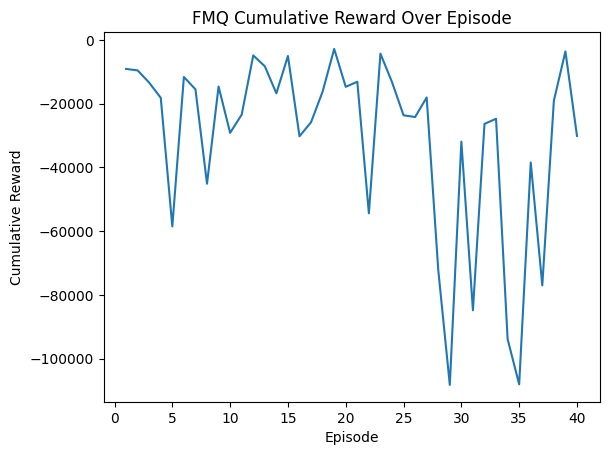

In [7]:
np.random.seed(10)
class MultiAgentGridworldEnv(gym.Env):
    def __init__(self, rows, cols, goal_state, trap_state):
        super(MultiAgentGridworldEnv, self).__init__()

        self.rows = rows
        self.cols = cols
        self.goal_state = goal_state
        self.trap_state = trap_state

        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Discrete(rows * cols * 5)  # 5 for agent's previous action

        self.agent_pos = (4, 0)
        self.agent_prev_action = None
        self.agent_action_counts = np.zeros(4)  # Frequency of agent's action selections

        self.adversary_action_counts = np.zeros((rows, cols, 4, 5))  # Frequency of adversary's action selections

    def reset(self):
        self.agent_pos = (4, 0)
        self.agent_prev_action = None
        return self._get_state()

    def _get_state(self):
        return (self.agent_pos[0], self.agent_pos[1], self.agent_prev_action)

    def _apply_wind(self):
        wind_effect = 0
        if self.agent_prev_action == 0:
            wind_effect = -1
        elif self.agent_prev_action == 3:
            wind_effect = 1
        return wind_effect

    def step(self, agent_action):
        movements = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        wind_effect = self._apply_wind()

        next_pos = (
            self.agent_pos[0] + movements[agent_action][0] + wind_effect,
            self.agent_pos[1] + movements[agent_action][1]
        )

        next_pos = (
            np.clip(next_pos[0], 0, self.rows - 1),
            np.clip(next_pos[1], 0, self.cols - 1)
        )

        self.agent_pos = next_pos
        self.agent_prev_action = agent_action
        self.agent_action_counts[agent_action] += 1

        # Adversary's turn
        adversary_action = self._select_adversary_action()

        # Update adversary's action counts
        self.adversary_action_counts[self.agent_pos[0], self.agent_pos[1], adversary_action, self.agent_prev_action] += 1

        # Define rewards
        if self.agent_pos == self.goal_state:
            reward = 10
        elif self.agent_pos == self.trap_state:
            reward = -100
            self.reset()
        else:
            reward = -1

        return self._get_state(), reward, False, {}

    def _select_adversary_action(self):
        # Choose the action with the maximum Q-value and minimum frequency
        max_q_value = np.max(-q_values_agent[self.agent_pos[0], self.agent_pos[1], :])
        min_frequency_action = np.argmin(self.adversary_action_counts[self.agent_pos[0], self.agent_pos[1], :, self.agent_prev_action])

        return min_frequency_action

np.random.seed(12)

# Parameters
learning_rate = 0.8
discount_factor = 0.9
epsilon = 0.8
decay_rate = 0.02
num_episodes = 40
min_epsilon = 0.7

# Initialize Q-values for agent and adversary
rows, cols = 8, 8
goal_state = (4, 7)
trap_state = (4, 4)
q_values_agent = np.zeros((rows, cols, 4))  # 4 actions: Up, Down, Left, Right
q_values_adversary = np.zeros((rows, cols, 4, 5))  # 4 actions and 5 agent's previous actions

# Gym environment
env = MultiAgentGridworldEnv(rows, cols, goal_state, trap_state)

# Function to choose an action using epsilon-greedy policy
def epsilon_greedy_policy(q_values, state):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(env.action_space.n)
    else:
        return np.argmax(q_values[state])

cumulative_rewards = []

# FMQ algorithm
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    # Update exploration rate
    if epsilon > min_epsilon:
        epsilon -= decay_rate

    while state[0:2] != goal_state:
        # Agent's turn
        agent_action = epsilon_greedy_policy(q_values_agent, state)

        # Adversary's turn
        adversary_action = env._select_adversary_action()

        next_state, reward, done, _ = env.step(agent_action)

        # Update agent's Q-values using the FMQ update rule
        q_values_agent[state[0], state[1], agent_action] += learning_rate * (
            reward + discount_factor * np.max(q_values_adversary[next_state[0], next_state[1], :, :]) -
            q_values_agent[state[0], state[1], agent_action]
        )

        # Update adversary's Q-values
        q_values_adversary[state[0], state[1], adversary_action, state[2]] += learning_rate * (
            -reward + discount_factor * np.max(-q_values_agent[next_state[0], next_state[1], :]) +
            q_values_adversary[state[0], state[1], adversary_action, state[2]]
        )

        state = next_state
        total_reward += reward

    cumulative_rewards.append(total_reward)

# Plot cumulative rewards
plt.plot(np.arange(1, num_episodes + 1), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('FMQ Cumulative Reward Over Episode')
plt.show()

## JAL

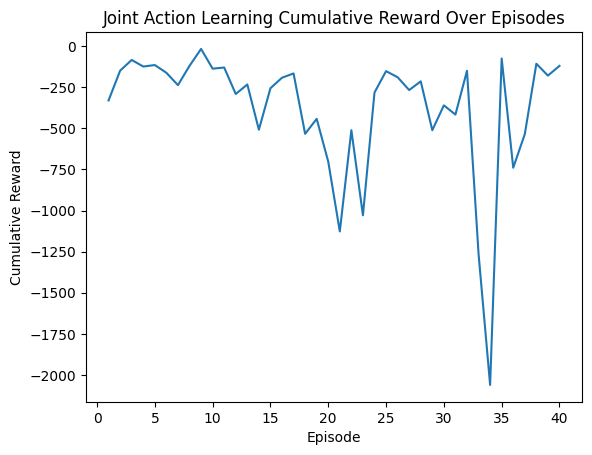

In [8]:
np.random.seed(10)
class JointActionLearningEnv(gym.Env):
    def __init__(self, rows, cols, goal_state, trap_state):
        super(JointActionLearningEnv, self).__init__()

        self.rows = rows
        self.cols = cols
        self.goal_state = goal_state
        self.trap_state = trap_state

        self.action_space = gym.spaces.Discrete(4)  # 4 actions: Up, Down, Left, Right
        self.observation_space = gym.spaces.Discrete(rows * cols)

        # Agent and adversary initial positions
        self.agent_pos = (4, 0)
        self.adversary_pos = (0, 0)

    def reset(self):
        # Reset the agent and adversary to their initial positions
        self.agent_pos = (4, 0)
        self.adversary_pos = (0, 0)
        return self._get_state()

    def _get_state(self):
        return (self.agent_pos[0] * self.cols + self.agent_pos[1])

    def _apply_wind(self, agent_action):
        wind_effect = 0
        if agent_action == 0:
            wind_effect = -1
        elif agent_action == 3:
            wind_effect = 1
        return wind_effect

    def step(self, agent_action, adversary_action):
        # Possible movements
        movements = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Right, Left, Down, Up

        # Apply wind effect to agent
        wind_effect = self._apply_wind(agent_action)

        # Update agent's position with wind effect
        next_agent_pos = (
            self.agent_pos[0] + movements[agent_action][0] + wind_effect,
            self.agent_pos[1] + movements[agent_action][1]
        )

        # Clip agent's position to stay within the grid
        next_agent_pos = (
            np.clip(next_agent_pos[0], 0, self.rows - 1),
            np.clip(next_agent_pos[1], 0, self.cols - 1)
        )

        # Update adversary's position
        self.adversary_pos = (
            np.clip(self.adversary_pos[0] + movements[adversary_action][0], 0, self.rows - 1),
            np.clip(self.adversary_pos[1] + movements[adversary_action][1], 0, self.cols - 1)
        )

        # Define rewards
        if next_agent_pos == self.goal_state:
            reward = 10  # Goal state, no additional reward
            done = True
        elif next_agent_pos == self.trap_state:
            reward = -100  # Trap state, penalty
            done = True
        else:
            reward = -1  # Default step penalty
            done = False

        self.agent_pos = next_agent_pos

        return self._get_state(), reward, done, {}

# Parameters
learning_rate = 0.8
discount_factor = 0.9
epsilon = 0.5
decay_rate = 0.02
num_episodes = 40
min_epsilon = 0.04

rows, cols = 9, 9
goal_state = (4, 8)
trap_state = (4, 4)

# Create environment
env = JointActionLearningEnv(rows, cols, goal_state, trap_state)

# Run JAL Q-learning algorithm
q_values_agent = np.zeros((env.observation_space.n, env.action_space.n))
q_values_adversary = np.zeros((env.observation_space.n, env.action_space.n))
cumulative_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    if epsilon > min_epsilon:
        epsilon -= decay_rate

    while not done:
        # Agent's turn
        if np.random.rand() < epsilon:
            agent_action = np.random.choice(env.action_space.n)
        else:
            agent_action = np.argmax(q_values_agent[state])

        # Adversary's turn
        adversary_action = np.argmax(q_values_adversary[state])

        next_state, reward, done, _ = env.step(agent_action, adversary_action)

        # Update Q-values using the Joint Action Learning update rule
        q_values_agent[state, agent_action] += learning_rate * (
            reward + discount_factor * np.min(q_values_adversary[next_state]) - q_values_agent[state, agent_action]
        )

        q_values_adversary[state] += learning_rate * (
            -reward + discount_factor * np.max(q_values_agent[next_state]) - q_values_adversary[state]
        )

        state = next_state
        total_reward += reward
    cumulative_rewards.append(total_reward)

# Plot cumulative rewards
plt.plot(np.arange(1, num_episodes + 1), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Joint Action Learning Cumulative Reward Over Episodes')
plt.show()